In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

#sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error

#keras
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, BatchNormalization, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.experimental.preprocessing import Normalization


#others
import os
import json
from pathlib import Path
import joblib
import folium
import geojson
import geopandas as gpd
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBRegressor, plot_importance, plot_tree
import statsmodels.api as sm
from pandas.plotting import lag_plot
from matplotlib.pyplot import figure
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
data = yf.download('NVDA AMD INTC', start='2014-01-01', end='2021-08-04', group_by='ticker')

[*********************100%***********************]  3 of 3 completed


In [3]:
data

NVDA                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2014-01-02    3.980000    3.995000    3.930000    3.965000    3.745882   
2014-01-03    3.972500    3.980000    3.905000    3.917500    3.701007   
2014-01-06    3.957500    4.000000    3.920000    3.970000    3.750606   
2014-01-07    4.010000    4.050000    3.982500    4.035000    3.812013   
2014-01-08    4.050000    4.110000    4.035000    4.090000    3.863974   
...                ...         ...         ...         ...         ...   
2021-07-28  193.190002  196.460007  189.949997  195.029999  194.971725   
2021-07-29  195.190002  198.529999  193.279999  196.619995  196.561264   
2021-07-30  194.179993  196.300003  192.630005  194.990005  194.931763   
2021-08-02  197.000000  199.610001  193.610001  197.500000  197.441010   
2021-08-03  197.399994  202.220001  192.199997  198.149994  198.090790   

                             AMD                                      \
              Volume        Open        High         Low       Close   
Date                                                                   
2014-01-02  26009200    3.850000    3.980000    3.840000    3.950000   
2014-01-03  25933200    3.980000    4.000000    3.880000    4.000000   
2014-01-06  40949200    4.010000    4.180000    3.990000    4.130000   
2014-01-07  33328800    4.190000    4.250000    4.110000    4.180000   
2014-01-08  30819200    4.230000    4.260000    4.140000    4.180000   
...              ...         ...         ...         ...         ...   
2021-07-28  20219100   93.440002   98.709999   89.650002   97.930000   
2021-07-29  19078100   96.580002  105.739998   96.580002  102.949997   
2021-07-30  18322900  101.599998  106.970001  101.379997  106.190002   
2021-08-02  21744400  105.930000  110.330002  103.830002  108.629997   
2021-08-03  30181100  108.150002  114.849998  107.660004  112.559998   

                                        INTC                                   \
             Adj Close     Volume       Open       High        Low      Close   
Date                                                                            
2014-01-02    3.950000   20548400  25.780001  25.820000  25.469999  25.790001   
2014-01-03    4.000000   22887200  25.860001  25.900000  25.600000  25.780001   
2014-01-06    4.130000   42398300  25.770000  25.790001  25.450001  25.459999   
2014-01-07    4.180000   42932100  25.540001  25.730000  25.469999  25.590000   
2014-01-08    4.180000   30678700  25.639999  25.709999  25.299999  25.430000   
...                ...        ...        ...        ...        ...        ...   
2021-07-28   97.930000  140561000  53.029999  53.919998  52.939999  53.070000   
2021-07-29  102.949997  164091800  53.480000  54.099998  53.320000  53.700001   
2021-07-30  106.190002  125567000  53.650002  53.900002  53.250000  53.720001   
2021-08-02  108.629997  115581900  53.990002  54.470001  53.540001  53.680000   
2021-08-03  112.559998  157723100  53.889999  54.160000  53.259998  54.060001   

                                 
            Adj Close    Volume  
Date                             
2014-01-02  20.678701  31833300  
2014-01-03  20.670675  27796700  
2014-01-06  20.414099  28682300  
2014-01-07  20.518333  19665100  
2014-01-08  20.390039  29680500  
...               ...       ...  
2021-07-28  52.363216  28478800  
2021-07-29  52.984829  16886600  
2021-07-30  53.004562  16460000  
2021-08-02  52.965096  18098100  
2021-08-03  53.340031  16375900  

[1910 rows x 18 columns]

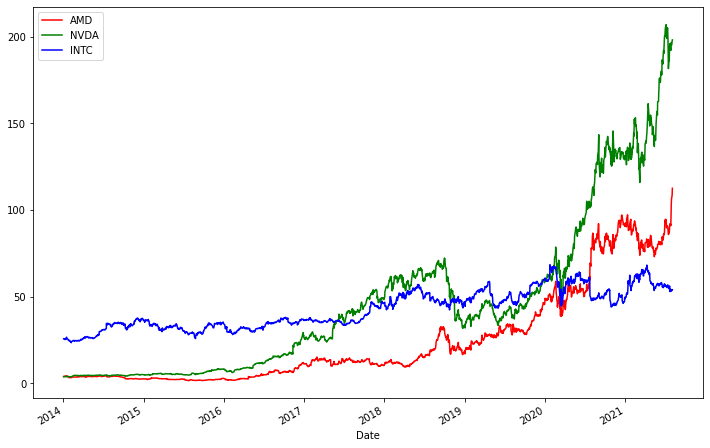

In [4]:
data['AMD']['Close'].plot(figsize=(12,8), color='red', label='AMD')
data['NVDA']['Close'].plot(color='green', label='NVDA')
data['INTC']['Close'].plot(color='blue', label='INTC')
plt.legend()

In [5]:
tickers_list = ['NVDA', 'AMD', 'INTC']
tickers_data = {}

for ticker in tickers_list:
    ticker_object = yf.Ticker(ticker)

    temp = pd.DataFrame.from_dict(ticker_object.info, orient='index')
    temp.reset_index(inplace=True)
    temp.columns = ['Attribute', 'Recent']

    tickers_data[ticker] = temp

tickers_data

{'NVDA':                Attribute                                             Recent
 0                    zip                                              95051
 1                 sector                                         Technology
 2      fullTimeEmployees                                              18975
 3    longBusinessSummary  NVIDIA Corporation operates as a visual comput...
 4                   city                                        Santa Clara
 ..                   ...                                                ...
 146        dividendYield                                             0.0005
 147              bidSize                                               1200
 148              dayHigh                                             304.68
 149   regularMarketPrice                                              292.9
 150             logo_url               https://logo.clearbit.com/nvidia.com
 
 [151 rows x 2 columns],
 'AMD':                Attribute         

In [6]:
#full list of infos

#'zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'state', 'country', 'companyOfficers', 'website', 'maxAge',
# 'address1', 'industry', 'previousClose', 'regularMarketOpen', 'twoHundredDayAverage', 'trailingAnnualDividendYield', 'payoutRatio', 'volume24Hr',
#  'regularMarketDayHigh', 'navPrice', 'averageDailyVolume10Day', 'totalAssets', 'regularMarketPreviousClose', 'fiftyDayAverage', 'trailingAnnualDividendRate',
#  'open', 'toCurrency', 'averageVolume10days', 'expireDate', 'yield', 'algorithm', 'dividendRate', 'exDividendDate', 'beta', 'circulatingSupply', 'startDate',
#  'regularMarketDayLow', 'priceHint', 'currency', 'trailingPE', 'regularMarketVolume', 'lastMarket', 'maxSupply', 'openInterest', 'marketCap', 'volumeAllCurrencies',
#  'strikePrice', 'averageVolume', 'priceToSalesTrailing12Months', 'dayLow', 'ask', 'ytdReturn', 'askSize', 'volume', 'fiftyTwoWeekHigh', 'forwardPE', 'fromCurrency',
#  'fiveYearAvgDividendYield', 'fiftyTwoWeekLow', 'bid', 'tradeable', 'dividendYield', 'bidSize', 'dayHigh', 'exchange', 'shortName', 'longName', 'exchangeTimezoneName',
#  'exchangeTimezoneShortName', 'isEsgPopulated', 'gmtOffSetMilliseconds', 'quoteType', 'symbol', 'messageBoardId', 'market', 'annualHoldingsTurnover', 'enterpriseToRevenue',
#  'beta3Year', 'profitMargins', 'enterpriseToEbitda', '52WeekChange', 'morningStarRiskRating', 'forwardEps', 'revenueQuarterlyGrowth', 'sharesOutstanding', 'fundInceptionDate',
#  'annualReportExpenseRatio', 'bookValue', 'sharesShort', 'sharesPercentSharesOut', 'fundFamily', 'lastFiscalYearEnd', 'heldPercentInstitutions', 'netIncomeToCommon',
#  'trailingEps', 'lastDividendValue', 'SandP52WeekChange', 'priceToBook', 'heldPercentInsiders', 'nextFiscalYearEnd', 'mostRecentQuarter', 'shortRatio',
#  'sharesShortPreviousMonthDate', 'floatShares', 'enterpriseValue', 'threeYearAverageReturn', 'lastSplitDate', 'lastSplitFactor', 'legalType', 'lastDividendDate',
#  'morningStarOverallRating', 'earningsQuarterlyGrowth', 'dateShortInterest', 'pegRatio', 'lastCapGain', 'shortPercentOfFloat', 'sharesShortPriorMonth',
#  'impliedSharesOutstanding', 'category', 'fiveYearAverageReturn', 'regularMarketPrice', 'logo_url'

In [7]:
combined_data = pd.concat(tickers_data)
combined_data = combined_data.reset_index()
combined_data = combined_data.drop(columns=['level_1'], axis=1)
combined_data.columns = ['Ticker', 'Attributes', 'Recent']
combined_data

#looking at the attributes of the 3 tickers (NVDA, AMD, INTC)

,Ticker,Attributes,Recent
0,NVDA,zip,95051
1,NVDA,sector,Technology
2,NVDA,fullTimeEmployees,18975
3,NVDA,longBusinessSummary,NVIDIA Corporation operates as a visual comput...
4,NVDA,city,Santa Clara
...,...,...,...
448,INTC,dividendYield,0.0261
449,INTC,bidSize,1300
450,INTC,dayHigh,53.93
451,INTC,regularMarketPrice,53.14


In [8]:
combined_data['Attributes']

0                      zip
1                   sector
2        fullTimeEmployees
3      longBusinessSummary
4                     city
              ...         
448          dividendYield
449                bidSize
450                dayHigh
451     regularMarketPrice
452               logo_url
Name: Attributes, Length: 453, dtype: object

In [9]:
employees = combined_data[combined_data['Attributes'] == 'fullTimeEmployees']
employees.sort_values(by='Recent', ascending=False)

#INTC is a much bigger company relative in employees count

,Ticker,Attributes,Recent
304,INTC,fullTimeEmployees,117200
2,NVDA,fullTimeEmployees,18975
153,AMD,fullTimeEmployees,12600


In [10]:
market_cap = combined_data[combined_data['Attributes'] == 'marketCap'].drop(columns='Attributes', axis=1)
company_hq = combined_data[combined_data['Attributes'] == 'city'].drop(columns='Attributes', axis=1)
five_year_div_yield = combined_data[combined_data['Attributes'] == 'fiveYearAvgDividendYield'].drop(columns='Attributes', axis=1)
company_hq.columns = ['Ticker', 'City']
market_cap.columns = ['Ticker', 'Market Cap']
five_year_div_yield.columns = ['Ticker', 'Dividend Yield (5 Years)']

In [11]:
market_cap
#nvda 800bil
#amd 187bil
#intc 200bil

,Ticker,Market Cap
132,NVDA,729906806784
283,AMD,174403026944
434,INTC,216120377344


In [12]:
company_comparison = pd.merge(market_cap, company_hq, left_on='Ticker', right_on='Ticker')
company_comparison = pd.merge(company_comparison, five_year_div_yield, left_on='Ticker', right_on='Ticker')
company_comparison

#high dividend yield for INTC. No dividend for AMD

,Ticker,Market Cap,City,Dividend Yield (5 Years)
0,NVDA,729906806784,Santa Clara,0.25
1,AMD,174403026944,Santa Clara,None
2,INTC,216120377344,Santa Clara,2.48


In [13]:
heldInsiders = combined_data[combined_data['Attributes'] == 'heldPercentInsiders']
year_change = combined_data[combined_data['Attributes'] == '52WeekChange']


In [14]:
year_change_and_insiders = pd.merge(heldInsiders, year_change, on='Ticker')
year_change_and_insiders = year_change_and_insiders.rename(columns={'Recent_x': "insidersHeld", "Recent_y": "yearly_change"})
year_change_and_insiders

,Ticker,Attributes_x,insidersHeld,Attributes_y,yearly_change
0,NVDA,heldPercentInsiders,0.04079,52WeekChange,1.387808
1,AMD,heldPercentInsiders,0.00421,52WeekChange,0.663235
2,INTC,heldPercentInsiders,0.00073,52WeekChange,0.041292


<AxesSubplot:xlabel='insidersHeld', ylabel='yearly_change'>

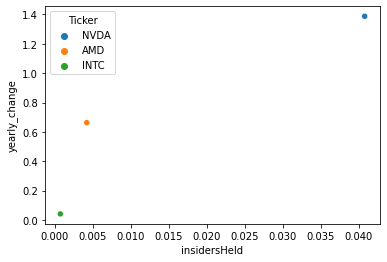

In [15]:
sns.scatterplot(data=year_change_and_insiders, x='insidersHeld', y='yearly_change', hue='Ticker')
#potentially looking at insiders holding for stocks to gauge the yearly_change

In [16]:
os.getcwd()

'c:\\Users\\huyho\\OneDrive\\Desktop\\stuff\\p-projects\\stock-forecasting'

In [17]:
#coordinates of intc, nvda, and amd HQ
latitude = [37.3860884556, 37.3691018569, 37.38242485333451]
longitude = [-121.958119501, -121.9582395, -121.97017259436115]
comp_ticker = ['INTC', 'NVDA', 'AMD']
color = ['blue', 'green', 'red'] 

t = zip(latitude, longitude, comp_ticker, color)
result_t = set(t)
result_t

{(37.3691018569, -121.9582395, 'NVDA', 'green'),
 (37.38242485333451, -121.97017259436115, 'AMD', 'red'),
 (37.3860884556, -121.958119501, 'INTC', 'blue')}

In [18]:
#given that they are all headquartered in Santa Clara, let's visualize the proximity of these companies

m = folium.Map([37.3541, -121.9552], zoom_start=12)

for lat, lon, ticker, color in result_t:
    folium.Marker([lat, lon], popup=ticker, icon=folium.Icon(color=color)).add_to(m)
m

In [19]:
nvda_table = data['NVDA']
nvda_table['Month'] = nvda_table['Open'].index.month
nvda_month_grouped = nvda_table.groupby('Month').mean()

amd_table = data['AMD']
amd_table['Month'] = amd_table['Open'].index.month
amd_month_grouped = amd_table.groupby('Month').mean()

intc_table = data['INTC']
intc_table['Month'] = intc_table['Open'].index.month
intc_month_grouped = intc_table.groupby('Month').mean()

intc_month_grouped

<ipython-input-19-3d10f01f01a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_table['Month'] = nvda_table['Open'].index.month
<ipython-input-19-3d10f01f01a9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amd_table['Month'] = amd_table['Open'].index.month
<ipython-input-19-3d10f01f01a9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

,Open,High,Low,Close,Adj Close,Volume
Month,,,,,,
1,42.463148,43.017901,41.996975,42.496667,38.431227,3.470906e+07
2,43.011765,43.510654,42.551307,43.058889,39.273798,2.577163e+07
3,42.904057,43.660000,42.314514,42.972000,39.231479,3.082112e+07
4,44.498976,45.017289,43.961506,44.499157,40.624378,2.816236e+07
5,42.757798,43.185774,42.358095,42.792678,39.183768,2.311837e+07
6,43.275581,43.639070,42.816337,43.219477,39.612779,2.665397e+07
7,43.044706,43.443294,42.615588,43.063529,39.409491,2.866230e+07
8,39.818397,40.153782,39.471667,39.815833,36.071714,2.524401e+07
9,40.490210,40.894825,40.134895,40.551608,36.685905,2.592782e+07


<AxesSubplot:xlabel='Month', ylabel='Volume'>

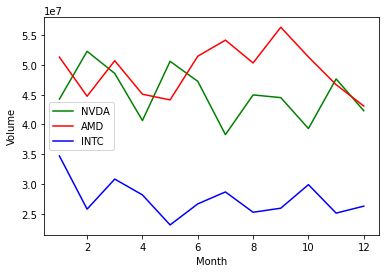

In [20]:
sns.lineplot(x=nvda_month_grouped['Volume'].index, y=nvda_month_grouped['Volume'], label='NVDA', color='green')
sns.lineplot(x=amd_month_grouped['Volume'].index, y=amd_month_grouped['Volume'], label='AMD', color='red')
sns.lineplot(x=intc_month_grouped['Volume'].index, y=intc_month_grouped['Volume'], label='INTC', color='blue')
#volume seems to decrease significantly during the summer months

# Examine data before applying time-series

Common time-series data patterns:

- Level: The average value in the series
- Trend: Increases, decreases, stable
- Seasonal or Periodic: Does the pattern repeats over time
- Cyclical: Pattern that increases and decreases but usually related to non-seasonal activity, ie. business cycles
- Random or Irregular Variations: Increases and decreases that don't have any apparent patterns

<p2> The stock market prices probably falls into the Random and Irregular variations. For the model to be perfect, we must take into account financial records, social media activities, mergers and acquisitions, etc. Simply using previous prices will not yield a good model. However, we must work with the limited data that we possess.

In [21]:
def decomp():
    pass


# Using ARIMA

<p1> ARIMA models expect p, d, q as input parameters <p1>
1. p is the number of lag observations.
2. d is the degree of differencing.
3. q is the size/width of the moving average window. 


In [22]:
nvda = pd.DataFrame(data['NVDA']['Close'])
nvda.columns = ['Close']
nvda

,Close
Date,
2014-01-02,3.965000
2014-01-03,3.917500
2014-01-06,3.970000
2014-01-07,4.035000
2014-01-08,4.090000
...,...
2021-07-28,195.029999
2021-07-29,196.619995
2021-07-30,194.990005


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 5)'>

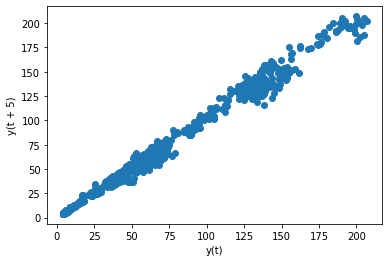

In [23]:
#let's look at the autocorrelation
lag_plot(nvda['Close'], lag=5)

In [24]:
train_nvda, test_nvda = nvda[0:int(len(nvda) * 0.8)], nvda[int(len(nvda) * 0.8):]
print('training set shape', train_nvda.shape)
print('testing set shape', test_nvda.shape)

training set shape (1528, 1)
testing set shape (382, 1)


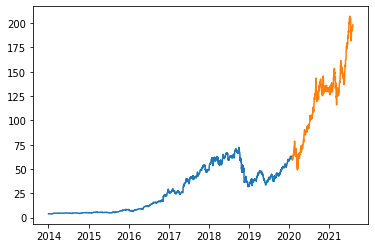

In [25]:
plt.plot(train_nvda)
plt.plot(test_nvda)

In [26]:
train_nvda, test_nvda = train_nvda.values, test_nvda.values

In [27]:
history = [x for x in train_nvda]
model_predictions = []
N_test_observations = len(test_nvda) #382

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_nvda[time_point]
    history.append(true_test_value)

mse_error = mean_squared_error(test_nvda, model_predictions)
print('Testing MSE is', mse_error)

C:\Users\huyho\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing MSE is 12.550908427899701


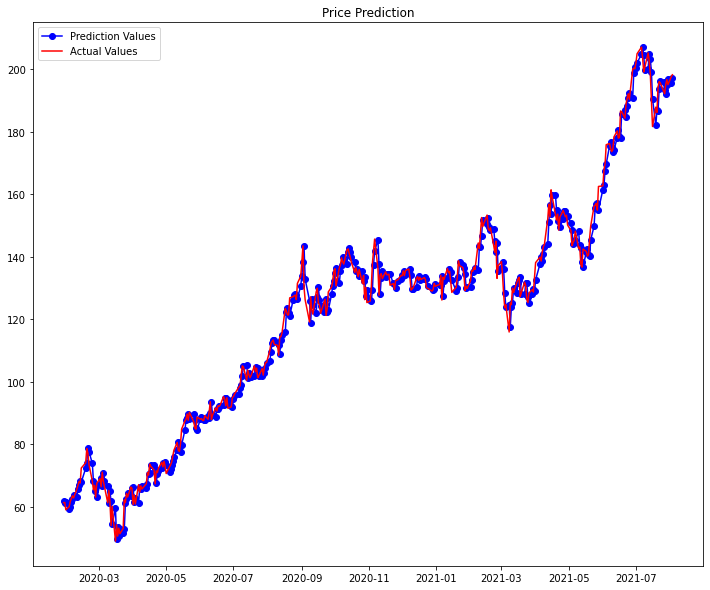

In [28]:
test_set_range = nvda[int(len(nvda) * 0.8):].index

plt.figure(figsize=(12,10))
plt.plot(test_set_range, model_predictions, color='blue', label='Prediction Values', marker='o')
plt.plot(test_set_range, test_nvda, color='red', label='Actual Values')

plt.title('Price Prediction')
plt.legend()
plt.show()

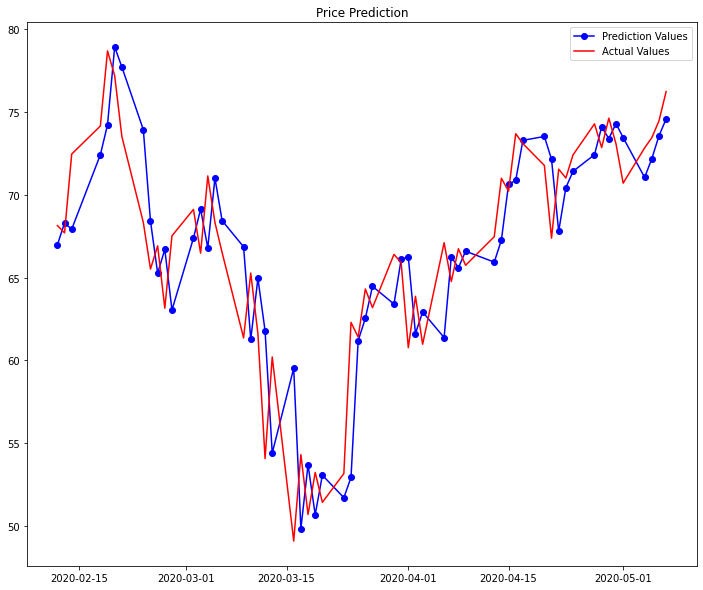

In [29]:
#looking at a smaller subset
plt.figure(figsize=(12,10))
plt.plot(test_set_range[10:70], model_predictions[10:70], color='blue', label='Prediction Values', marker='o')
plt.plot(test_set_range[10:70], test_nvda[10:70], color='red', label='Actual Values')

plt.title('Price Prediction')
plt.legend()
plt.show()

In [30]:
y_arima = train_nvda
y_arima

array([[ 3.96499991],
       [ 3.91750002],
       [ 3.97000003],
       ...,
       [62.61999893],
       [60.04999924],
       [61.99250031]])

In [31]:
armamodel = SARIMAX(y_arima, order = (1, 0,1))

In [32]:
armamodel = armamodel.fit()

C:\Users\huyho\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [33]:
y_pred_arma = armamodel.get_forecast(len(test_nvda))
y_pred_df = y_pred_arma.conf_int(alpha = 0.05)
y_pred_df

array([[60.12841585, 63.69292779],
       [59.42262843, 64.3715409 ],
       [58.87216559, 64.89483538],
       [58.40407893, 65.33575965],
       [57.98921437, 65.72346778],
       [57.61239977, 66.07313191],
       [57.26454307, 66.3938441 ],
       [56.9396853 , 66.69156331],
       [56.63366964, 66.97044638],
       [56.34345968, 67.2335297 ],
       [56.06675726, 67.48311142],
       [55.80177323, 67.72098072],
       [55.54708225, 67.94856291],
       [55.301527  , 68.16701532],
       [55.06415244, 68.377293  ],
       [54.83415953, 68.58019497],
       [54.61087172, 68.77639777],
       [54.39371019, 68.96648025],
       [54.18217509, 69.15094224],
       [53.97583129, 69.33021888],
       [53.77429716, 69.50469178],
       [53.57723584, 69.67469781],
       [53.38434818, 69.84053612],
       [53.19536709, 70.00247379],
       [53.01005292, 70.16075048],
       [52.82818966, 70.3155822 ],
       [52.64958181, 70.46716443],
       [52.47405176, 70.61567479],
       [52.30143754,

## ARIMA seems to do a pretty decent job. Of course there are instances where it might not be as reliable, for example during the market crash during the Covid-19 pandemic. However, it looks like a reliable model that is relatively simple to build.

# Using XGBOOST

In [34]:
xgboost_nvda = data['NVDA']

In [35]:
xgboost_nvda['target'] = xgboost_nvda['Close'].copy()
xgboost_nvda['target'] = xgboost_nvda['Close'].shift(-1)
xgboost_nvda.dropna(inplace=True)
xgboost_nvda

<ipython-input-35-e29f684a3415>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_nvda['target'] = xgboost_nvda['Close'].copy()
<ipython-input-35-e29f684a3415>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_nvda['target'] = xgboost_nvda['Close'].shift(-1)
<ipython-input-35-e29f684a3415>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,Open,High,Low,Close,Adj Close,Volume,target
Date,,,,,,,
2014-01-02,3.980000,3.995000,3.930000,3.965000,3.745882,26009200,3.917500
2014-01-03,3.972500,3.980000,3.905000,3.917500,3.701007,25933200,3.970000
2014-01-06,3.957500,4.000000,3.920000,3.970000,3.750606,40949200,4.035000
2014-01-07,4.010000,4.050000,3.982500,4.035000,3.812013,33328800,4.090000
2014-01-08,4.050000,4.110000,4.035000,4.090000,3.863974,30819200,3.937500
...,...,...,...,...,...,...,...
2021-07-27,192.649994,196.220001,187.410004,192.080002,192.022629,24886300,195.029999
2021-07-28,193.190002,196.460007,189.949997,195.029999,194.971725,20219100,196.619995
2021-07-29,195.190002,198.529999,193.279999,196.619995,196.561264,19078100,194.990005


In [36]:
xgboost_nvda['target'][0] == xgboost_nvda['Close'][1]
#the target is the next date's closing price

True

In [37]:
xgboost_nvda_train, xgboost_nvda_test = xgboost_nvda[0:int(len(xgboost_nvda) * 0.8)], xgboost_nvda[int(len(xgboost_nvda) * 0.8):]
print('train length: ', len(xgboost_nvda_train))
print('test length: ', len(xgboost_nvda_test))

train length:  1527
test length:  382


In [38]:
train_X= xgboost_nvda_train.iloc[:, :-1]
train_Y= xgboost_nvda_train.iloc[:, -1]
test_X = xgboost_nvda_test.iloc[:, :-1]
test_Y = xgboost_nvda_test.iloc[:, -1]

In [39]:
train_X

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,3.980000,3.995000,3.930000,3.965000,3.745882,26009200
2014-01-03,3.972500,3.980000,3.905000,3.917500,3.701007,25933200
2014-01-06,3.957500,4.000000,3.920000,3.970000,3.750606,40949200
2014-01-07,4.010000,4.050000,3.982500,4.035000,3.812013,33328800
2014-01-08,4.050000,4.110000,4.035000,4.090000,3.863974,30819200
...,...,...,...,...,...,...
2020-01-21,61.952499,62.322498,61.642502,61.985001,61.828880,21791600
2020-01-22,62.439999,63.397499,62.250000,62.527500,62.370014,23924000
2020-01-23,62.930000,63.299999,62.037498,63.215000,63.055786,24451600


In [40]:
modelXGB = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
modelXGB.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

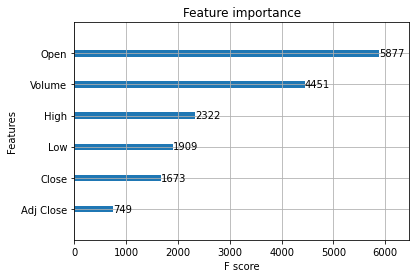

In [41]:
importance = plot_importance(modelXGB)

# Using Keras

In [42]:
nvda_train = nvda[:int(len(nvda) * 0.7)]
nvda_test = nvda[int(len(nvda) * 0.7):]
print('nvda train:' , len(nvda_train))
print('nvda test:' , len(nvda_test))

nvda train: 1337
nvda test: 573


In [43]:
display(nvda_train, nvda_test)

,Close
Date,
2014-01-02,3.965000
2014-01-03,3.917500
2014-01-06,3.970000
2014-01-07,4.035000
2014-01-08,4.090000
...,...
2019-04-18,46.575001
2019-04-22,47.117500
2019-04-23,47.667500


,Close
Date,
2019-04-26,44.522499
2019-04-29,44.832500
2019-04-30,45.250000
2019-05-01,45.117500
2019-05-02,45.797501
...,...
2021-07-28,195.029999
2021-07-29,196.619995
2021-07-30,194.990005


In [44]:
scaler = MinMaxScaler()
scaler.fit(nvda_train)

MinMaxScaler()

In [45]:
scaled_train = scaler.transform(nvda_train)
scaled_test = scaler.transform(nvda_test)

In [46]:
n_input = 300 #window size of 300
n_feature = 1 #univariate


#creating the generator for training and testing
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

In [47]:
#MODEL

model = Sequential()

model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', input_shape=(n_input, n_feature))) #(200, 1)
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=n_feature)) #1
model.compile(optimizer='adam', loss='mse')

#stochastic gradient descent sgd, mse is best for outlier detection

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 300, 512)          2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 256)          393472    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 75, 128)           98432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 37, 64)            2

In [49]:
model.fit(train_generator, epochs=5, batch_size=50, verbose=2)

Epoch 1/5
1037/1037 - 14s - loss: 0.0113
Epoch 2/5
1037/1037 - 5s - loss: 0.0010
Epoch 3/5
1037/1037 - 5s - loss: 0.0016
Epoch 4/5
1037/1037 - 5s - loss: 8.7144e-04
Epoch 5/5
1037/1037 - 5s - loss: 9.1431e-04


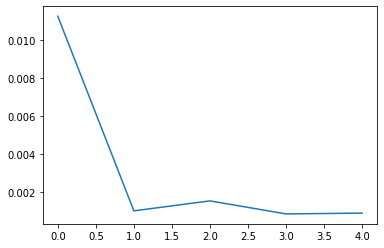

In [50]:
model_loss= model.history.history['loss']
plt.plot(range(len(model_loss)), model_loss)

In [85]:
""" for x,y in test_generator:
    a = x
    b = y
    print("samples: {}, predictions: {}" .format(a, b)) """
    
#weird

' for x,y in test_generator:\n    a = x\n    b = y\n    print("samples: {}, predictions: {}" .format(a, b)) '

In [52]:
test_predictions = []
train_predictions = []

#how far into the future will I forecast?
#loop through test window
for x,_ in test_generator:
    
    # One timestep ahead of historical 300 points
    current_pred = model.predict(x)
    
    #store that prediction
    test_predictions.append(current_pred[0])

#train window
for x,_ in train_generator:
    
    # One timestep ahead of historical 300 points
    current_pred_train = model.predict(x)
    
    #store that prediction
    train_predictions.append(current_pred_train[0])


#reverse the scaled into normal prices
train_predictions = scaler.inverse_transform(train_predictions)
true_predictions = scaler.inverse_transform(test_predictions)

In [53]:
test_result = nvda_test[n_input:]
test_result['predictions'] = true_predictions
test_result

<ipython-input-53-597e54aba391>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = true_predictions


,Close,predictions
Date,,
2020-07-06,98.392502,100.131766
2020-07-07,98.717499,102.172318
2020-07-08,102.160004,103.624106
2020-07-09,105.089996,106.229800
2020-07-10,104.792503,109.571006
...,...,...
2021-07-28,195.029999,189.358809
2021-07-29,196.619995,191.870637
2021-07-30,194.990005,193.958151


<AxesSubplot:xlabel='Date', ylabel='Close'>

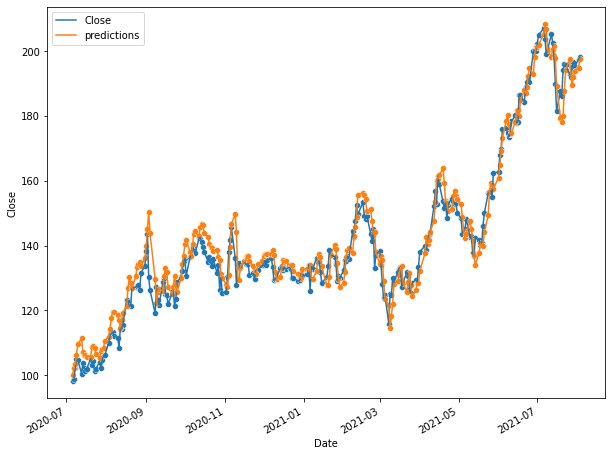

In [54]:
test_result[['Close', 'predictions']].plot(figsize=(10,8))
sns.scatterplot(x=test_result.index, y=test_result.Close)
sns.scatterplot(x=test_result.index, y=test_result.predictions)

<AxesSubplot:xlabel='Date'>

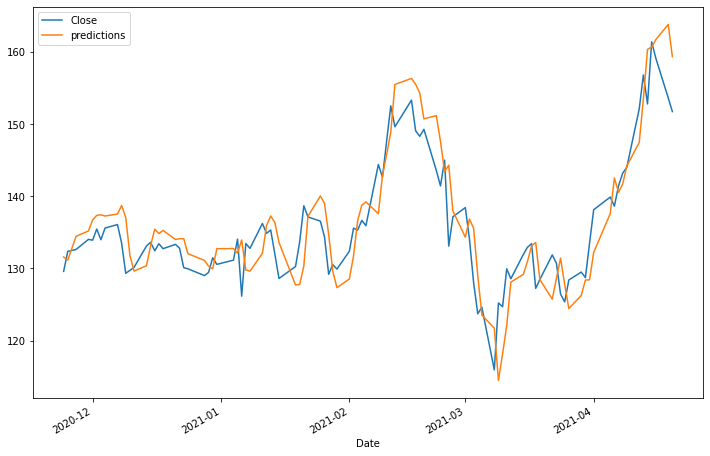

In [55]:
#looking at a smaller subset
test_result[['Close', 'predictions']][100:200].plot(figsize=(12,8))

In [56]:
#train results
train_result = nvda_train[n_input:]
train_result['predictions'] = train_predictions
train_result

<ipython-input-56-8e83d9a31f84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result['predictions'] = train_predictions


,Close,predictions
Date,,
2015-03-13,5.675000,6.194597
2015-03-16,5.742500,6.220268
2015-03-17,5.812500,6.236732
2015-03-18,5.717500,6.267902
2015-03-19,5.805000,6.279377
...,...,...
2019-04-18,46.575001,49.232383
2019-04-22,47.117500,49.079731
2019-04-23,47.667500,49.350665


<AxesSubplot:xlabel='Date'>

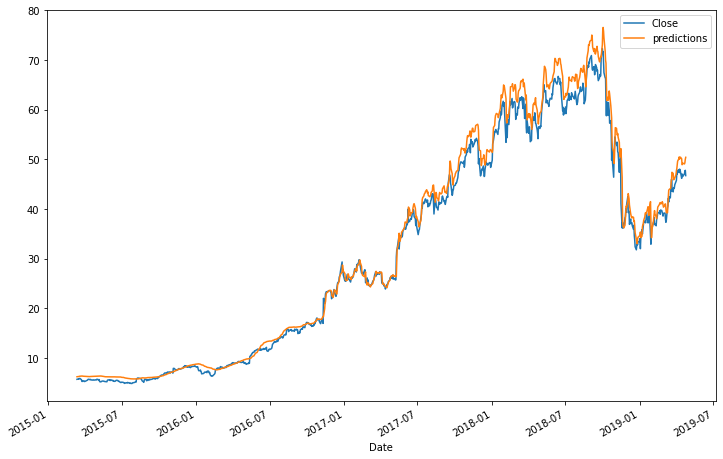

In [57]:
train_result.plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

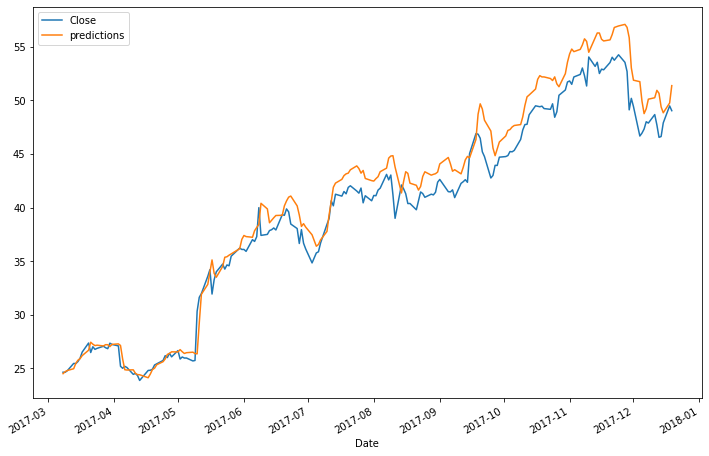

In [58]:
train_result[500:700].plot(figsize=(12,8))

In [59]:
test_result

,Close,predictions
Date,,
2020-07-06,98.392502,100.131766
2020-07-07,98.717499,102.172318
2020-07-08,102.160004,103.624106
2020-07-09,105.089996,106.229800
2020-07-10,104.792503,109.571006
...,...,...
2021-07-28,195.029999,189.358809
2021-07-29,196.619995,191.870637
2021-07-30,194.990005,193.958151


In [60]:
mse = mean_squared_error(y_true=test_result['Close'], y_pred=test_result['predictions'])
mse
#mse of ~90 is decent.

24.69639137451799

#test

LET'S TEST ON AMD DATA

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 300, 512)          2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 256)          393472    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 75, 128)           98432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 37, 64)            2

In [62]:
amd = pd.DataFrame(data['AMD']['Close'])
amd.columns = ['Close']
amd

,Close
Date,
2014-01-02,3.950000
2014-01-03,4.000000
2014-01-06,4.130000
2014-01-07,4.180000
2014-01-08,4.180000
...,...
2021-07-28,97.930000
2021-07-29,102.949997
2021-07-30,106.190002


In [63]:
scaler.fit(amd)
scaled_amd = scaler.transform(amd)
n_input = 300 #window size of 300
n_feature = 1 #univariate


#creating the generator for training and testing
generator_amd = TimeseriesGenerator(scaled_amd, scaled_amd, length=n_input, batch_size=1)

test_predictions = []

#how far into the future will I forecast?
#loop through test window
for x,_ in generator_amd:
    
    # One timestep ahead of historical 300 points
    current_pred = model.predict(x)
    
    #store that prediction
    test_predictions.append(current_pred[0])

#reverse the scaled into normal prices
true_predictions = scaler.inverse_transform(test_predictions)

In [64]:
test_result = amd[300:]
test_result['predictions'] = true_predictions
test_result

<ipython-input-64-522a893abb10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = true_predictions


,Close,predictions
Date,,
2015-03-13,2.750000,4.626527
2015-03-16,2.760000,4.623967
2015-03-17,2.770000,4.620849
2015-03-18,2.750000,4.617860
2015-03-19,2.740000,4.614847
...,...,...
2021-07-28,97.930000,96.925799
2021-07-29,102.949997,101.175652
2021-07-30,106.190002,107.541722


<AxesSubplot:xlabel='Date', ylabel='Close'>

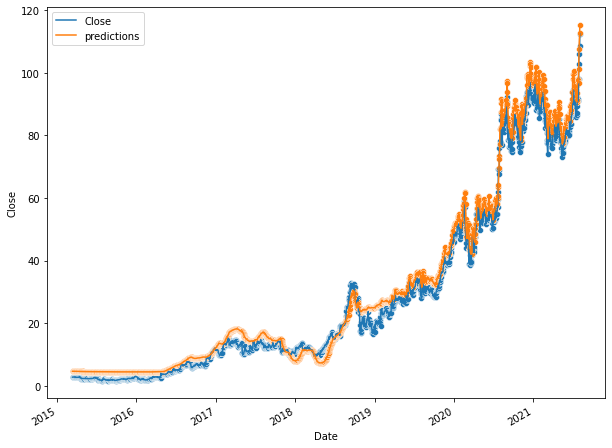

In [65]:
test_result[['Close', 'predictions']].plot(figsize=(10,8))
sns.scatterplot(x=test_result.index, y=test_result.Close)
sns.scatterplot(x=test_result.index, y=test_result.predictions)

In [66]:
mse_amd = mean_squared_error(test_result['Close'], test_result['predictions'])
mse_amd

10.977268919875533

In [67]:
def grab_ticker(ticker):
    data = yf.download(ticker, start='2014-01-01', end='2021-08-04')
    return data
    

In [68]:
def get_closing_df(ticker):
    data = grab_ticker(ticker)
    df = pd.DataFrame(data['Close'])
    df.columns = ['Close']
    return df

In [69]:
class PreProcessed_Model_2:
    
    def __init__(self, ticker):
        self.ticker = ticker
        self.n_input = 300
        self.n_feature = 1
        
    def build_model(self):
        self.model = Sequential()

        self.model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', input_shape=(n_input, n_feature))) #(300, 1)
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))
        
        self.model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

        self.model.add(Flatten())
        self.model.add(Dense(units=32, activation='relu'))
        self.model.add(Dense(units=n_feature)) #1
        self.model.compile(optimizer='adam', loss='mse')

        #stochastic gradient descent sgd, mse is best for outlier detection
        return self.model
    
    def preprocessed_data(self):
        
        df = get_closing_df(ticker)
        self.ticker_train = df[:int(len(df) * 0.7)]
        self.ticker_test = df[int(len(df) * 0.7):]
        scaler = MinMaxScaler()
        scaler.fit(self.ticker_train)
        scaled_train_ticker = scaler.transform(self.ticker_train)
        scaled_test_ticker = scaler.transform(self.ticker_test)
        
        #creating the generator for training and testing
        train_generator_ticker = TimeseriesGenerator(scaled_train_ticker, scaled_train_ticker, length=n_input, batch_size=1)
        test_generator_ticker = TimeseriesGenerator(scaled_test_ticker, scaled_test_ticker, length=n_input, batch_size=1)
        self.model.fit(train_generator_ticker, epochs=5, batch_size=50, verbose=2)
        
        
        test_predictions = []
        train_predictions = []

        #how far into the future will I forecast?
        #loop through test window
        for x,_ in test_generator_ticker:
            
            # One timestep ahead of historical 300 points
            current_pred = self.model.predict(x)
            
            #store that prediction
            test_predictions.append(current_pred[0])

        #train window
        for x,_ in train_generator_ticker:
            
            # One timestep ahead of historical 300 points
            current_pred_train = self.model.predict(x)
            
            #store that prediction
            train_predictions.append(current_pred_train[0])


        #reverse the scaled into normal prices
        self.train_predictions = scaler.inverse_transform(train_predictions)
        self.true_predictions = scaler.inverse_transform(test_predictions)
    
    def get_results(self):
        self.test_result = self.ticker_test[300:]
        self.test_result['predictions'] = self.true_predictions
        return self.test_result
        
    def plot_test_result_graph(self):
        self.test_result[['Close', 'predictions']].plot(figsize=(10,8))
        sns.scatterplot(x=self.test_result.index, y=self.test_result.Close).set(title='{} Result Predictions'.format(self.ticker))
        sns.scatterplot(x=self.test_result.index, y=self.test_result.predictions)
        
    def plot_train_result_graph(self):
        self.train_result = self.ticker_train[300:]
        self.train_result['predictions'] = self.train_predictions
        self.train_result.plot(figsize=(12,8))
        plt.title('{} Training Predictions'.format(self.ticker))
    
    def predict(self, target):
        df = get_closing_df(target)
        scaler.fit(df)
        scaled_test_df = scaler.transform(df)
        n_input = 300 #window size of 300
        n_feature = 1 #univariate


        #creating the generator for training and testing
        test_generator_df = TimeseriesGenerator(scaled_test_df, scaled_test_df, length=n_input, batch_size=1)

        test_predictions = []

        #how far into the future will I forecast?
        #loop through test window
        for x,_ in test_generator_df:
            
            # One timestep ahead of historical 300 points
            current_pred = self.model.predict(x)
            
            #store that prediction
            test_predictions.append(current_pred[0])



        #reverse the scaled into normal prices
        self.test_predictions = scaler.inverse_transform(test_predictions)
        
        test_result = df[300:]
        test_result['predictions'] = self.test_predictions
        print(test_result)
        
        test_result[['Close', 'predictions']].plot(figsize=(10,8))
        sns.scatterplot(x=test_result.index, y=test_result.Close)
        sns.scatterplot(x=test_result.index, y=test_result.predictions)
        mse = mean_squared_error(y_true=test_result['Close'], y_pred=test_result['predictions'])
        print('MSE is: {}'.format(mse))
        

In [70]:
test = PreProcessed_Model_2('NVDA')

In [71]:
test.build_model()

In [72]:
test.preprocessed_data()

[*********************100%***********************]  1 of 1 completed
Epoch 1/5
1037/1037 - 6s - loss: 0.0076
Epoch 2/5
1037/1037 - 6s - loss: 0.0012
Epoch 3/5
1037/1037 - 5s - loss: 0.0015
Epoch 4/5
1037/1037 - 5s - loss: 0.0013
Epoch 5/5
1037/1037 - 5s - loss: 0.0011


In [73]:
test.get_results()

<ipython-input-69-4089d9c52614>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_result['predictions'] = self.true_predictions


,Close,predictions
Date,,
2020-07-06,59.540001,59.403603
2020-07-07,58.310001,59.802996
2020-07-08,58.610001,58.859320
2020-07-09,58.419998,58.477015
2020-07-10,59.529999,58.533890
...,...,...
2021-07-28,53.070000,53.111506
2021-07-29,53.700001,53.019784
2021-07-30,53.720001,54.335918


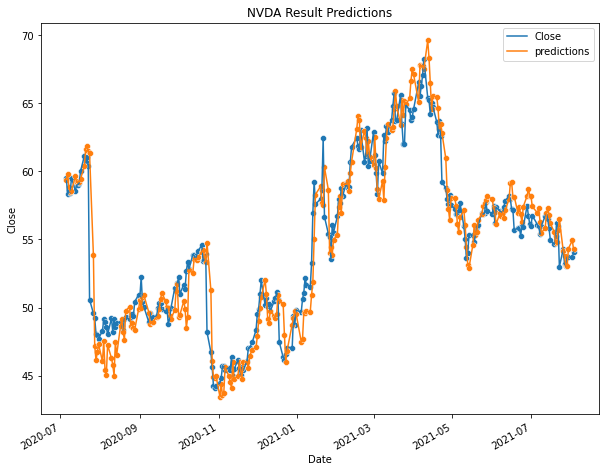

In [74]:
test.plot_test_result_graph()

<ipython-input-69-4089d9c52614>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_result['predictions'] = self.train_predictions


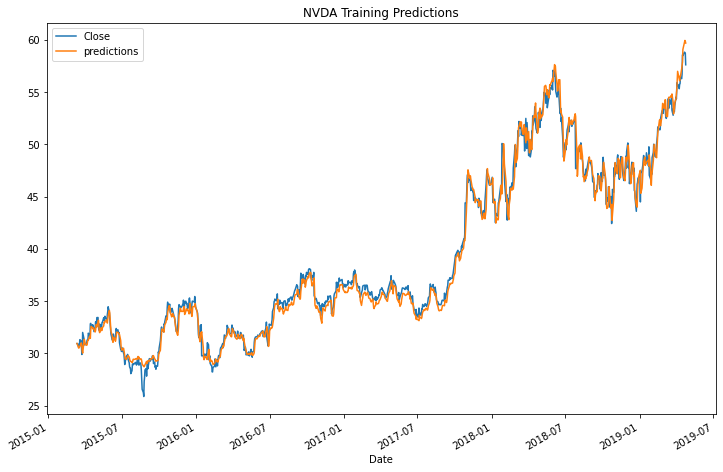

In [75]:
test.plot_train_result_graph()

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2015-03-13   66.257500    80.091495
2015-03-16   67.254997    80.022967
2015-03-17   66.125000    80.069023
2015-03-18   66.917503    79.997940
2015-03-19   66.809998    80.026653
...                ...          ...
2021-07-28  246.940002   257.392041
2021-07-29  247.919998   252.463237
2021-07-30  246.389999   250.912975
2021-08-02  239.779999   250.676689
2021-08-03  237.089996   245.656314

[1610 rows x 2 columns]
MSE is: 26.802601213242614


<ipython-input-69-4089d9c52614>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


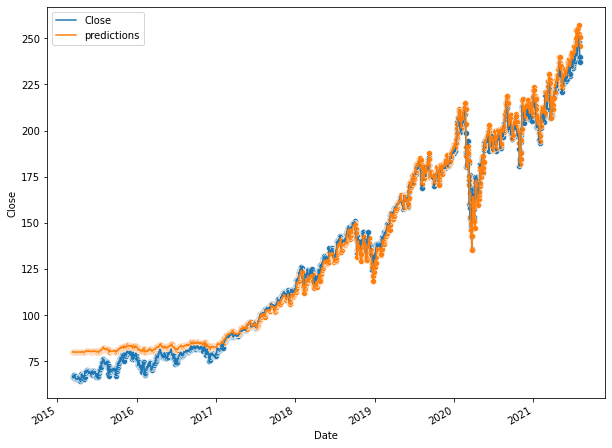

In [76]:
test.predict('V')

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2015-03-13  141.339996   140.267199
2015-03-16  144.130005   140.336970
2015-03-17  144.919998   141.734958
2015-03-18  145.160004   143.893510
2015-03-19  146.190002   144.020678
...                ...          ...
2021-07-28  399.459991   407.071811
2021-07-29  399.000000   408.069817
2021-07-30  399.049988   407.509879
2021-08-02  400.320007   407.890911
2021-08-03  398.329987   408.464953

[1610 rows x 2 columns]
MSE is: 37.96337696533288


<ipython-input-69-4089d9c52614>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


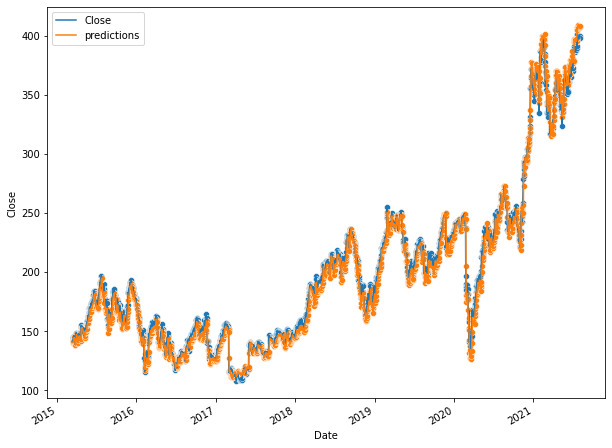

In [77]:
test.predict('PANW')

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2015-03-13   30.897499    38.210756
2015-03-16   31.237499    38.198007
2015-03-17   31.760000    38.270892
2015-03-18   32.117500    38.365387
2015-03-19   31.875000    38.504445
...                ...          ...
2021-07-28  144.979996   151.511467
2021-07-29  145.639999   148.150252
2021-07-30  145.860001   148.143178
2021-08-02  145.520004   148.962895
2021-08-03  147.360001   149.183568

[1610 rows x 2 columns]
MSE is: 35.02406979527774


<ipython-input-69-4089d9c52614>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


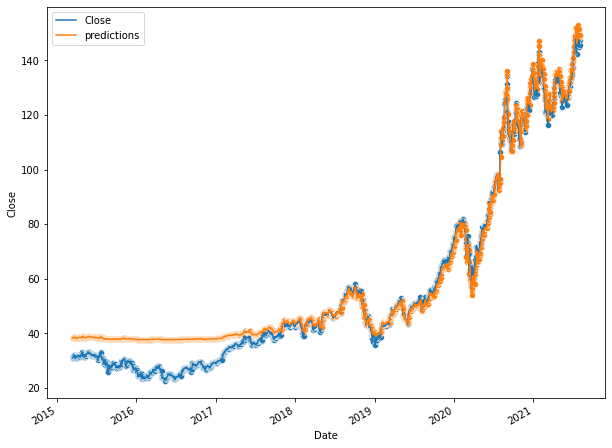

In [78]:
test.predict('AAPL')

[*********************100%***********************]  1 of 1 completed
                Close  predictions
Date                              
2015-03-13  27.940001    28.410271
2015-03-16  28.299999    28.242188
2015-03-17  28.150000    28.376828
2015-03-18  28.150000    28.311924
2015-03-19  28.260000    28.324109
...               ...          ...
2021-07-28  54.770000    56.380200
2021-07-29  55.070000    55.624263
2021-07-30  55.369999    55.722781
2021-08-02  55.450001    55.984733
2021-08-03  56.250000    55.797586

[1610 rows x 2 columns]
MSE is: 0.8789657196024493


<ipython-input-69-4089d9c52614>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


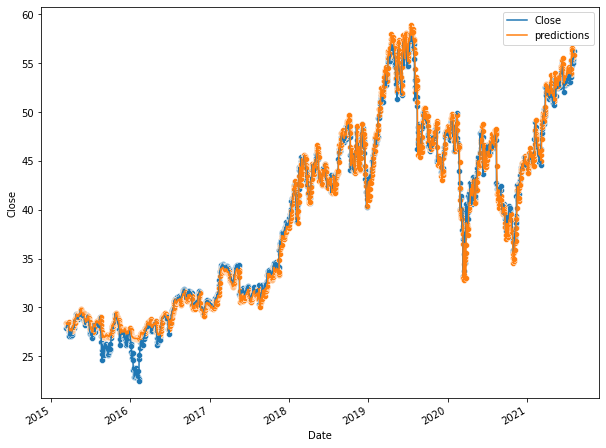

In [79]:
test.predict('CSCO')

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2015-03-13   40.700001    56.733432
2015-03-16   41.090000    56.902949
2015-03-17   40.910000    57.154220
2015-03-18   41.119999    57.159958
2015-03-19   40.790001    57.245913
...                ...          ...
2021-07-28  169.119995   161.911999
2021-07-29  164.860001   160.080952
2021-07-30  161.119995   139.337575
2021-08-02  157.649994   137.167884
2021-08-03  152.750000   146.342904

[1610 rows x 2 columns]
MSE is: 1420.6116070536307


<ipython-input-69-4089d9c52614>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


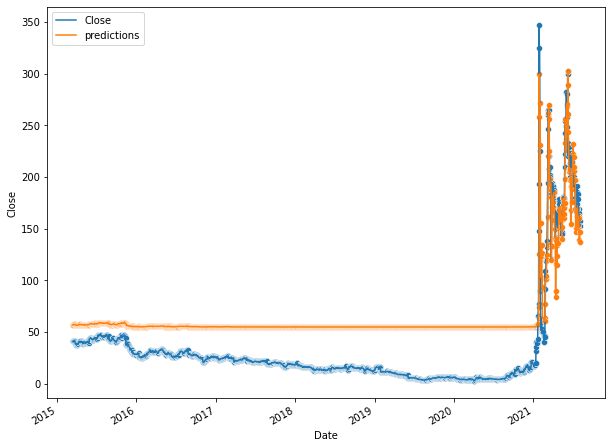

In [80]:
test.predict('GME')

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2020-11-19   65.889999    64.483800
2020-11-20   66.550003    64.159289
2020-11-23   66.089996    65.365973
2020-11-24   66.690002    65.926426
2020-11-25   69.989998    66.097559
...                ...          ...
2021-07-28  119.750000   118.699618
2021-07-29  120.389999   121.100705
2021-07-30  118.629997   122.594314
2021-08-02  118.589996   122.078452
2021-08-03  119.570000   120.605597

[176 rows x 2 columns]
MSE is: 10.72572843803479


<ipython-input-69-4089d9c52614>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


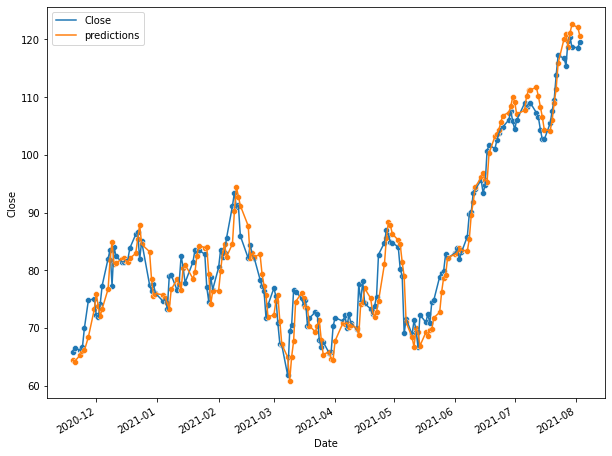

In [81]:
test.predict('NET')

[*********************100%***********************]  1 of 1 completed
                Close  predictions
Date                              
2015-03-13  30.930000    31.621002
2015-03-16  30.830000    31.390624
2015-03-17  30.590000    31.205478
2015-03-18  30.889999    31.155019
2015-03-19  30.740000    31.138503
...               ...          ...
2021-07-28  53.070000    52.819246
2021-07-29  53.700001    52.776906
2021-07-30  53.720001    54.032170
2021-08-02  53.680000    54.496020
2021-08-03  54.060001    53.978819

[1610 rows x 2 columns]
MSE is: 1.5745251721455202


<ipython-input-69-4089d9c52614>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


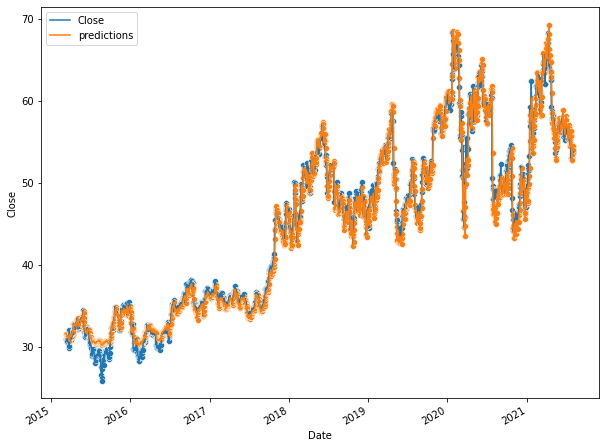

In [82]:
test.predict('INTC')

[*********************100%***********************]  1 of 1 completed
                Close  predictions
Date                              
2015-03-13  16.090000    16.522351
2015-03-16  16.129999    16.546544
2015-03-17  16.090000    16.541790
2015-03-18  15.980000    16.558078
2015-03-19  15.610000    16.520826
...               ...          ...
2021-07-28  38.130001    38.363274
2021-07-29  38.680000    38.539927
2021-07-30  38.360001    38.865125
2021-08-02  37.959999    38.844500
2021-08-03  38.549999    38.222977

[1610 rows x 2 columns]
MSE is: 0.9766737193800525


<ipython-input-69-4089d9c52614>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


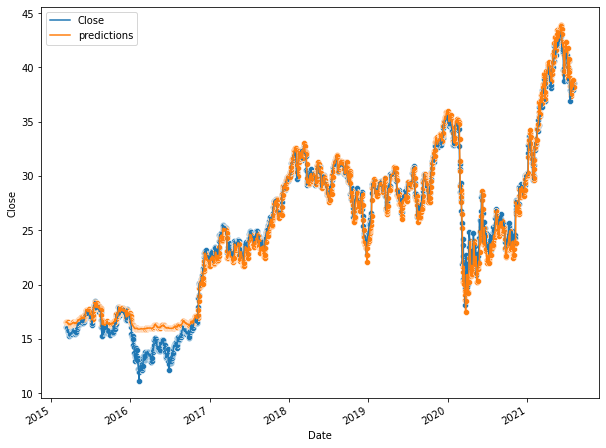

In [83]:
test.predict('BAC')

[*********************100%***********************]  1 of 1 completed
                Close  predictions
Date                              
2015-03-13  32.759998    32.476820
2015-03-16  33.060001    32.445765
2015-03-17  32.900002    32.570555
2015-03-18  33.590000    32.599783
2015-03-19  33.200001    33.062799
...               ...          ...
2021-07-28  28.010000    28.888516
2021-07-29  28.290001    28.922674
2021-07-30  28.049999    28.944031
2021-08-02  28.110001    28.794067
2021-08-03  28.190001    28.735510

[1610 rows x 2 columns]
MSE is: 0.3597364898824701


<ipython-input-69-4089d9c52614>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


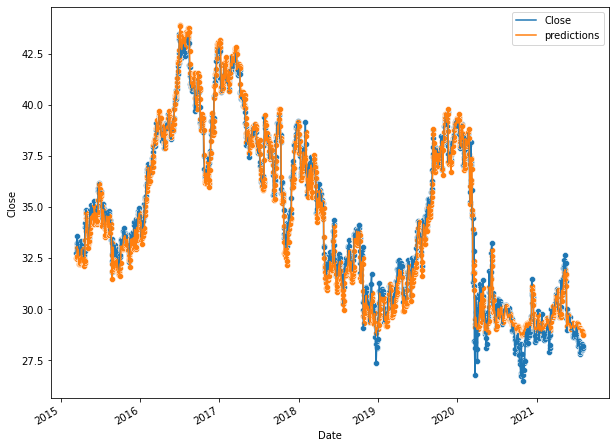

In [86]:
test.predict('T')

In [86]:
class PreProcessed:
    
    def __init__(self, ticker):
        self.ticker = ticker
        self.n_input = 300
        self.n_feature = 1
        
    def build_model(self):
        self.model = Sequential()

        self.model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', input_shape=(n_input, n_feature))) #(300, 1)
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

        self.model.add(Flatten())
        self.model.add(Dense(units=32, activation='relu'))
        self.model.add(Dense(units=n_feature)) #1
        self.model.compile(optimizer='adam', loss='mse')

        #stochastic gradient descent sgd, mse is best for outlier detection
        return self.model
    
    def preprocessed_data(self):
        
        df = get_closing_df(ticker)
        self.ticker_train = df[:int(len(df) * 0.7)]
        self.ticker_test = df[int(len(df) * 0.7):]
        scaler = MinMaxScaler()
        scaler.fit(self.ticker_train)
        scaled_train_ticker = scaler.transform(self.ticker_train)
        scaled_test_ticker = scaler.transform(self.ticker_test)
        
        #creating the generator for training and testing
        train_generator_ticker = TimeseriesGenerator(scaled_train_ticker, scaled_train_ticker, length=n_input, batch_size=1)
        test_generator_ticker = TimeseriesGenerator(scaled_test_ticker, scaled_test_ticker, length=n_input, batch_size=1)
        self.model.fit(train_generator_ticker, epochs=5, batch_size=50, verbose=2)
        
        
        test_predictions = []
        train_predictions = []

        #how far into the future will I forecast?
        #loop through test window
        for x,_ in test_generator_ticker:
            
            # One timestep ahead of historical 300 points
            current_pred = self.model.predict(x)
            
            #store that prediction
            test_predictions.append(current_pred[0])

        #train window
        for x,_ in train_generator_ticker:
            
            # One timestep ahead of historical 300 points
            current_pred_train = self.model.predict(x)
            
            #store that prediction
            train_predictions.append(current_pred_train[0])


        #reverse the scaled into normal prices
        self.train_predictions = scaler.inverse_transform(train_predictions)
        self.true_predictions = scaler.inverse_transform(test_predictions)
    
    def get_results(self):
        self.test_result = self.ticker_test[300:]
        self.test_result['predictions'] = self.true_predictions
        return self.test_result
        
    def plot_test_result_graph(self):
        self.test_result[['Close', 'predictions']].plot(figsize=(10,8))
        sns.scatterplot(x=self.test_result.index, y=self.test_result.Close).set(title='{} Result Predictions'.format(self.ticker))
        sns.scatterplot(x=self.test_result.index, y=self.test_result.predictions)
        
    def plot_train_result_graph(self):
        self.train_result = self.ticker_train[300:]
        self.train_result['predictions'] = self.train_predictions
        self.train_result.plot(figsize=(12,8))
        plt.title('{} Training Predictions'.format(self.ticker))
    
    def predict(self, target):
        df = get_closing_df(target)
        scaler.fit(df)
        scaled_test_df = scaler.transform(df)
        n_input = 300 #window size of 300
        n_feature = 1 #univariate


        #creating the generator for training and testing
        test_generator_df = TimeseriesGenerator(scaled_test_df, scaled_test_df, length=n_input, batch_size=1)

        test_predictions = []

        #how far into the future will I forecast?
        #loop through test window
        for x,_ in test_generator_df:
            
            # One timestep ahead of historical 300 points
            current_pred = self.model.predict(x)
            
            #store that prediction
            test_predictions.append(current_pred[0])



        #reverse the scaled into normal prices
        self.test_predictions = scaler.inverse_transform(test_predictions)
        
        test_result = df[300:]
        test_result['predictions'] = self.test_predictions
        print(test_result)
        
        test_result[['Close', 'predictions']].plot(figsize=(10,8))
        sns.scatterplot(x=test_result.index, y=test_result.Close)
        sns.scatterplot(x=test_result.index, y=test_result.predictions)
        mse = mean_squared_error(y_true=test_result['Close'], y_pred=test_result['predictions'])
        print('MSE is: {}'.format(mse))
        

In [87]:
p = PreProcessed('NVDA')

In [88]:
p.build_model()

In [89]:
p.preprocessed_data()

[*********************100%***********************]  1 of 1 completed
Epoch 1/5
1037/1037 - 11s - loss: 0.0140
Epoch 2/5
1037/1037 - 10s - loss: 0.0012
Epoch 3/5
1037/1037 - 10s - loss: 8.4191e-04
Epoch 4/5
1037/1037 - 10s - loss: 0.0013
Epoch 5/5
1037/1037 - 10s - loss: 9.3140e-04


In [90]:
p.get_results()

<ipython-input-86-f4eaf36932e9>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_result['predictions'] = self.true_predictions


,Close,predictions
Date,,
2020-07-06,98.392502,89.636845
2020-07-07,98.717499,91.601211
2020-07-08,102.160004,92.881883
2020-07-09,105.089996,95.102117
2020-07-10,104.792503,98.130140
...,...,...
2021-07-28,195.029999,167.798667
2021-07-29,196.619995,170.912170
2021-07-30,194.990005,172.676823


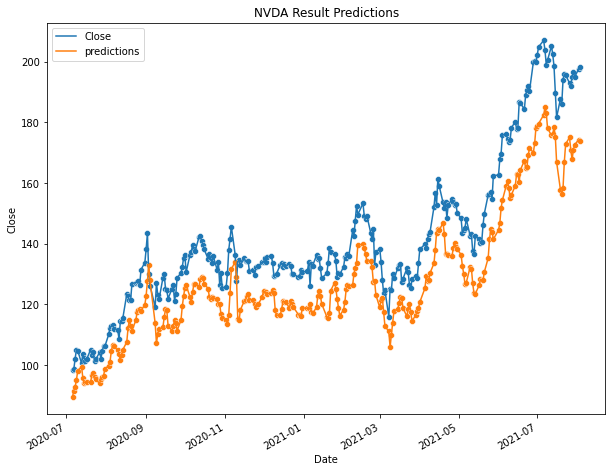

In [91]:
p.plot_test_result_graph()

<ipython-input-86-f4eaf36932e9>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_result['predictions'] = self.train_predictions


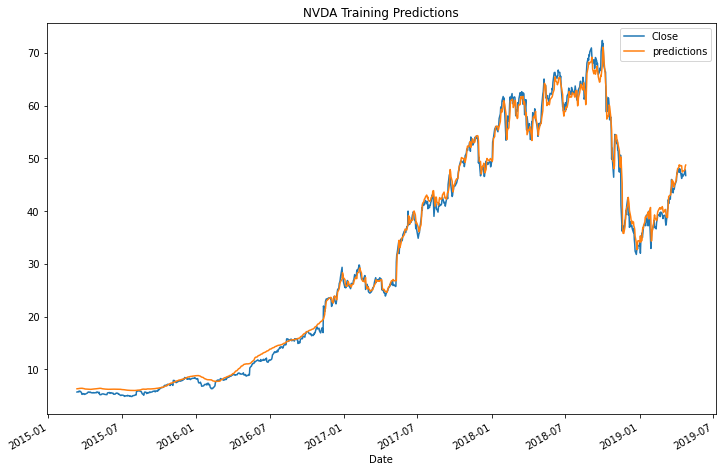

In [92]:
p.plot_train_result_graph()

In [93]:
p.ticker

'NVDA'

[*********************100%***********************]  1 of 1 completed


<ipython-input-86-f4eaf36932e9>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


                 Close  predictions
Date                               
2015-03-13   30.897499    36.790141
2015-03-16   31.237499    36.886416
2015-03-17   31.760000    36.976127
2015-03-18   32.117500    37.183647
2015-03-19   31.875000    37.342431
...                ...          ...
2021-07-28  144.979996   144.272537
2021-07-29  145.639999   141.338473
2021-07-30  145.860001   141.184885
2021-08-02  145.520004   140.803494
2021-08-03  147.360001   141.903097

[1610 rows x 2 columns]
MSE is: 75.19432111530234


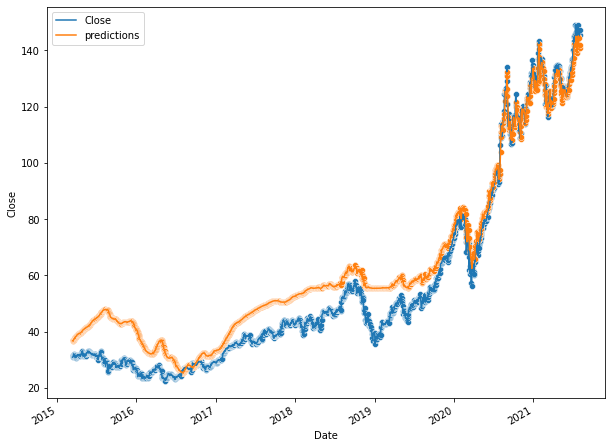

In [94]:
p.predict('AAPL')

[*********************100%***********************]  1 of 1 completed


<ipython-input-86-f4eaf36932e9>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


                 Close  predictions
Date                               
2015-03-13   66.257500    73.055760
2015-03-16   67.254997    73.118668
2015-03-17   66.125000    73.278934
2015-03-18   66.917503    73.428762
2015-03-19   66.809998    73.521069
...                ...          ...
2021-07-28  246.940002   245.605298
2021-07-29  247.919998   242.256918
2021-07-30  246.389999   239.871037
2021-08-02  239.779999   239.737350
2021-08-03  237.089996   236.006501

[1610 rows x 2 columns]
MSE is: 196.68260347553053


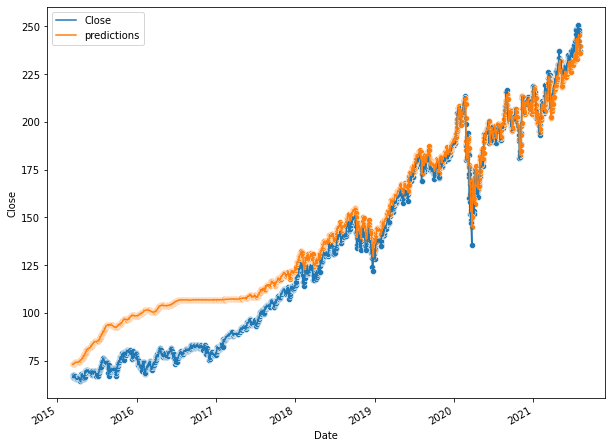

In [95]:
p.predict('V')

[*********************100%***********************]  1 of 1 completed


<ipython-input-86-f4eaf36932e9>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


                 Close  predictions
Date                               
2015-03-13  141.339996   146.238396
2015-03-16  144.130005   146.746452
2015-03-17  144.919998   148.058720
2015-03-18  145.160004   149.263151
2015-03-19  146.190002   149.880260
...                ...          ...
2021-07-28  399.459991   388.667809
2021-07-29  399.000000   389.527842
2021-07-30  399.049988   390.254416
2021-08-02  400.320007   390.823572
2021-08-03  398.329987   391.421431

[1610 rows x 2 columns]
MSE is: 273.0002499797759


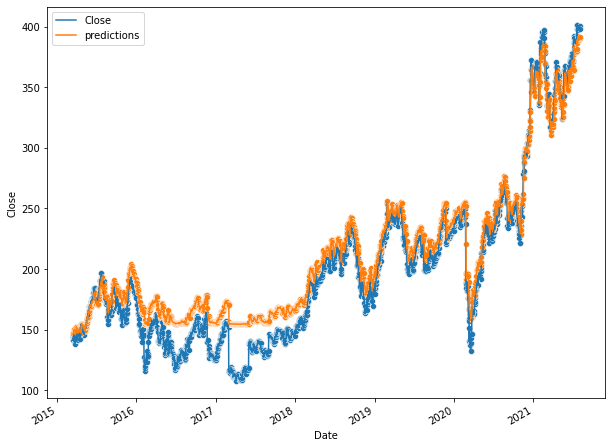

In [96]:
p.predict('PANW')

[*********************100%***********************]  1 of 1 completed


<ipython-input-86-f4eaf36932e9>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


                 Close  predictions
Date                               
2020-11-19   65.889999    62.356194
2020-11-20   66.550003    62.437155
2020-11-23   66.089996    63.428352
2020-11-24   66.690002    63.534436
2020-11-25   69.989998    63.696739
...                ...          ...
2021-07-28  119.750000   113.920914
2021-07-29  120.389999   115.037395
2021-07-30  118.629997   116.969941
2021-08-02  118.589996   116.968466
2021-08-03  119.570000   115.105243

[176 rows x 2 columns]
MSE is: 16.294593011318504


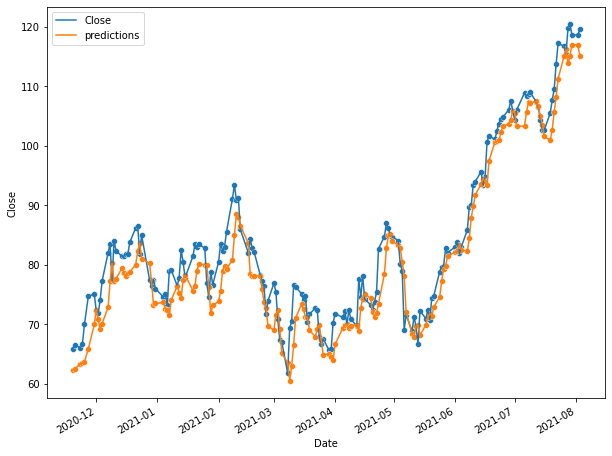

In [97]:
p.predict('NET')

[*********************100%***********************]  1 of 1 completed


<ipython-input-86-f4eaf36932e9>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


                 Close  predictions
Date                               
2015-03-13   40.700001   100.366758
2015-03-16   41.090000   100.334202
2015-03-17   40.910000   100.389287
2015-03-18   41.119999   100.393489
2015-03-19   40.790001   100.388763
...                ...          ...
2021-07-28  169.119995   161.064987
2021-07-29  164.860001   156.522330
2021-07-30  161.119995   154.401395
2021-08-02  157.649994   148.852729
2021-08-03  152.750000   141.704572

[1610 rows x 2 columns]
MSE is: 1028.436031520436


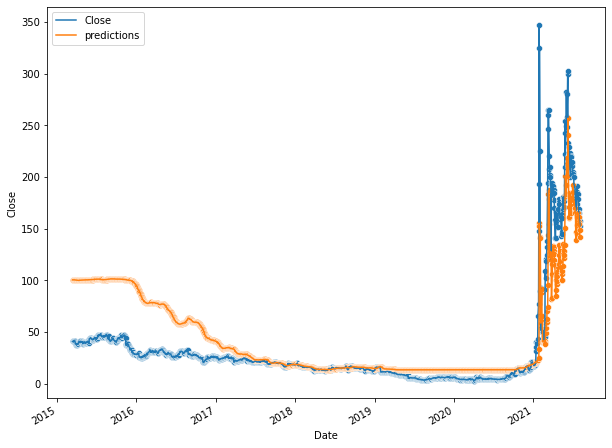

In [98]:
p.predict('GME')

[*********************100%***********************]  1 of 1 completed


<ipython-input-86-f4eaf36932e9>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


                Close  predictions
Date                              
2015-03-13  27.940001    29.353541
2015-03-16  28.299999    29.342570
2015-03-17  28.150000    29.381376
2015-03-18  28.150000    29.431027
2015-03-19  28.260000    29.460363
...               ...          ...
2021-07-28  54.770000    54.500518
2021-07-29  55.070000    53.913011
2021-07-30  55.369999    53.941356
2021-08-02  55.450001    54.250759
2021-08-03  56.250000    54.583669

[1610 rows x 2 columns]
MSE is: 3.9624770986522764


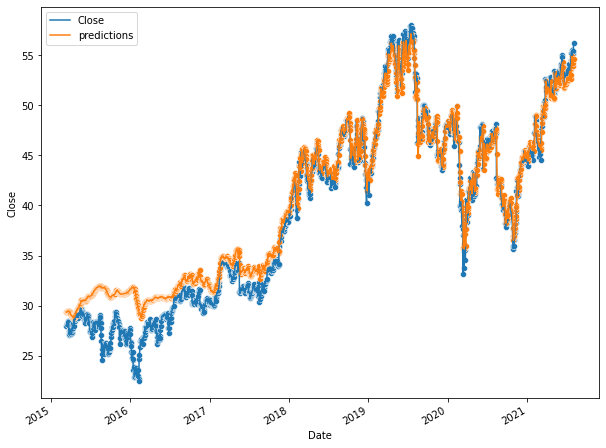

In [99]:
p.predict('CSCO')